In [443]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [444]:
data = pd.read_csv("airline-passenger-traffic.csv", header=None)

In [445]:
data.columns = ['Month','Passengers']

In [446]:
data['Month'] = pd.to_datetime(data['Month'], format = "%Y-%m")
data = data.set_index('Month')

In [447]:
data.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


# Timeseries Analysis

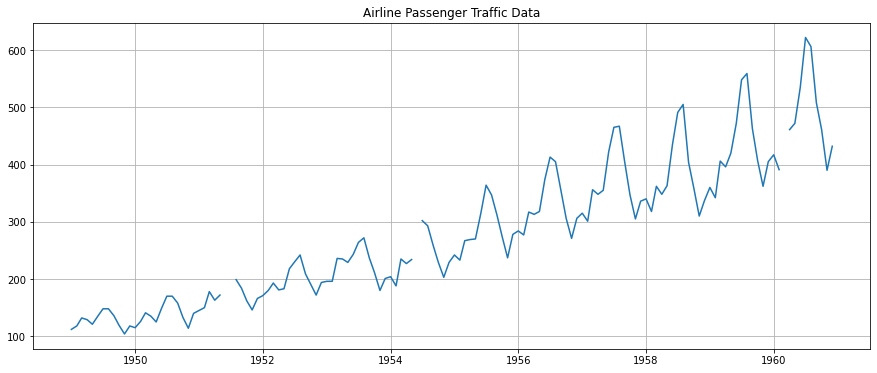

In [448]:
plt.figure(figsize=(15, 6))
plt.plot(data["Passengers"])
plt.title('Airline Passenger Traffic Data')
plt.grid(True)

## Missing Value Treatment method
### 1. Mean Imputation

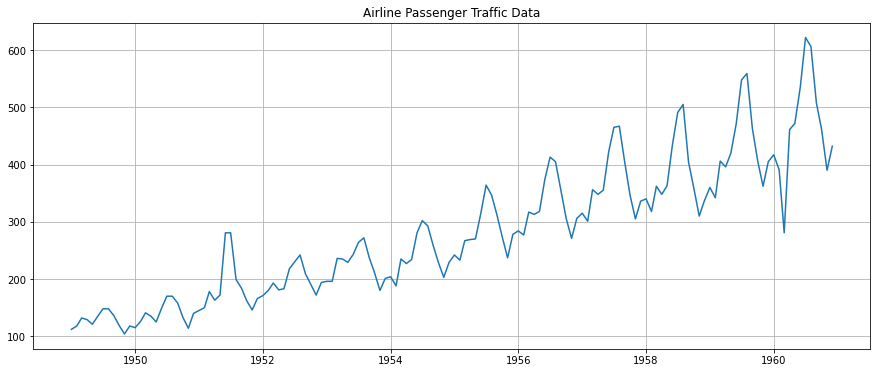

In [449]:
data = data.assign(Passengers_Mean_Imputation = data.Passengers.fillna(data.Passengers.mean()))
plt.figure(figsize=(15, 6))
plt.plot(data["Passengers_Mean_Imputation"])
plt.title('Airline Passenger Traffic Data')
plt.grid(True)
plt.show()

### 2. Linear Interpolation

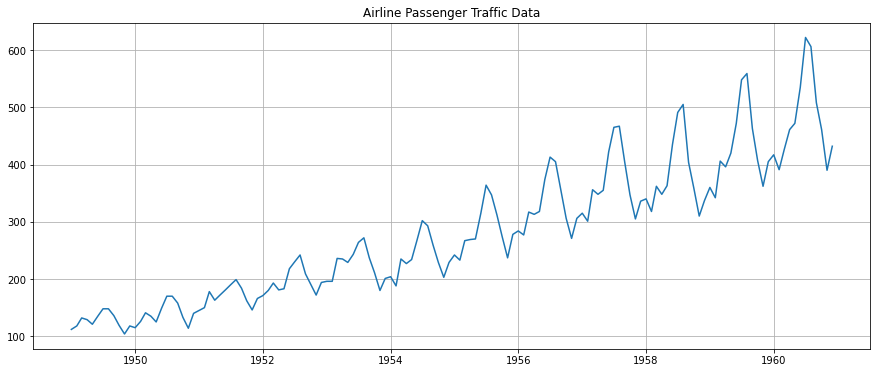

In [450]:
data = data.assign(Passengers_Linear_Interpolation = data.Passengers.interpolate(method='linear'))
plt.figure(figsize=(15,6))
plt.plot(data.Passengers_Linear_Interpolation)
plt.title('Airline Passenger Traffic Data')
plt.grid(True)
plt.show()

# Outlier Detection
#### 1. Box Plot and Interquartile Range

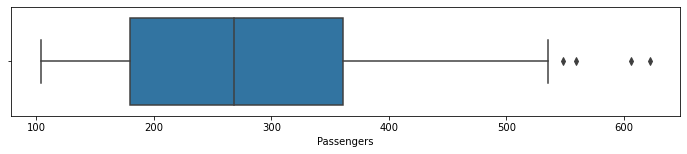

In [451]:
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x = data['Passengers'], whis =1 )

### 2. Histogram Plot

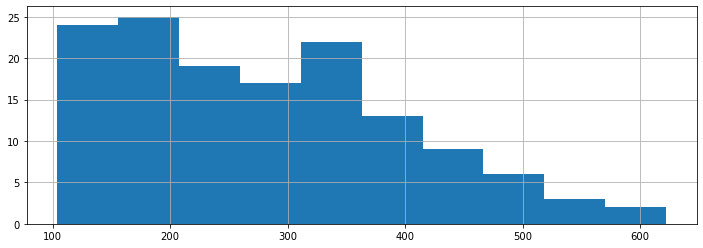

In [452]:
fig = data.Passengers.hist(figsize=(12,4))

After exploring the dataset we understood that there are no outliers in the dataset.

# Time - Series Decomposition
### 1. Additive Seasonal Decomposition

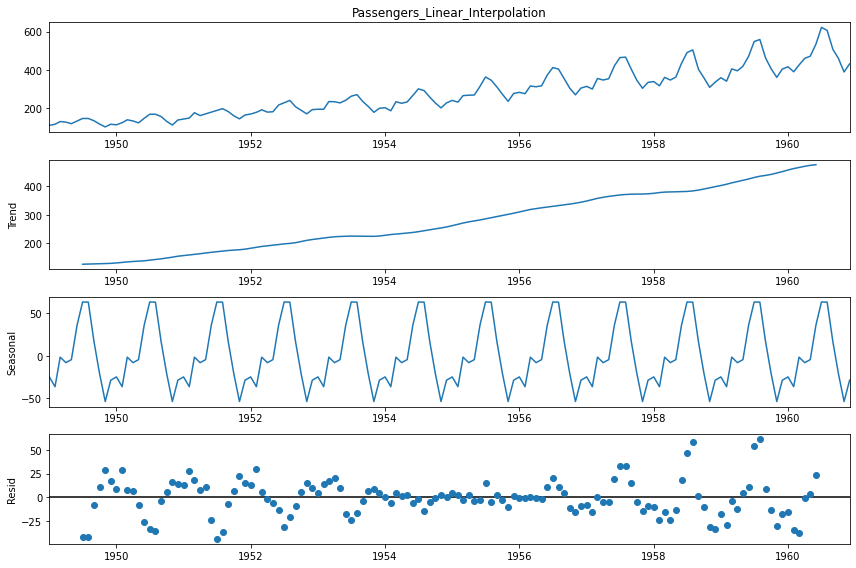

In [453]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data.Passengers_Linear_Interpolation, model = 'additive')
fig = decomposition.plot()
plt.show()

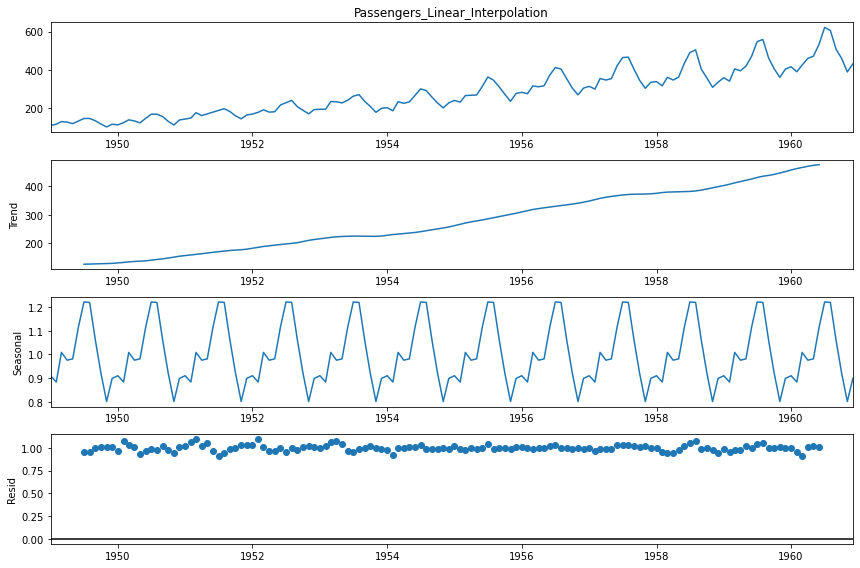

In [454]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers_Linear_Interpolation, model = 'multiplicative')
fig = decomposition.plot()
plt.show()

# Build and evaluate time series forecast
### Splitting time series into Training and Test sets

In [455]:
train_len = 120
train = data[0:train_len]
test = data[train_len:]

In [456]:
test.head()

,Passengers,Passengers_Mean_Imputation,Passengers_Linear_Interpolation
Month,,,
1959-01-01,360.0,360.0,360.0
1959-02-01,342.0,342.0,342.0
1959-03-01,406.0,406.0,406.0
1959-04-01,396.0,396.0,396.0
1959-05-01,420.0,420.0,420.0


## Naive Method

In [457]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] =  train['Passengers_Linear_Interpolation'][train_len-1]

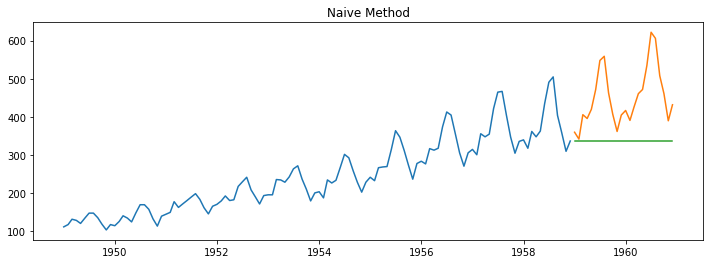

In [458]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_naive['naive_forecast'], label = 'Naive Forecast')
plt.title("Naive Method")
plt.show()

In [459]:
y_hat_avarage = test.copy()
y_hat_avarage['avg_forecat'] = train['Passengers_Linear_Interpolation'].mean()

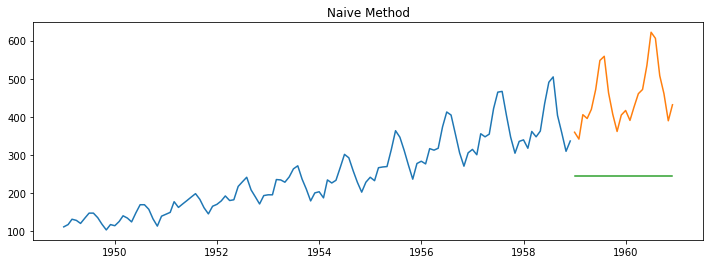

In [460]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_avarage['avg_forecat'], label = 'Naive Forecast')
plt.title("Naive Method")
plt.show()

# Calculate RSME and MAPE to evaluate forecast

In [461]:
from sklearn.metrics import mean_squared_error
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_naive['naive_forecast'])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_naive['naive_forecast'] )/test['Passengers_Linear_Interpolation'])*100,2)
results = pd.DataFrame({'Method':['Naive Method'], 'MAPE':[mape],'RSME':[rsme]})
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436


In [462]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_avarage['avg_forecat'])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_avarage['avg_forecat'] )/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Avarage Method'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485


# Simple Moving Average Method

In [463]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forcast'] = data['Passengers_Linear_Interpolation'].rolling(ma_window).mean()
y_hat_sma['sma_forcast'][train_len:] = y_hat_sma['sma_forcast'][train_len -1]

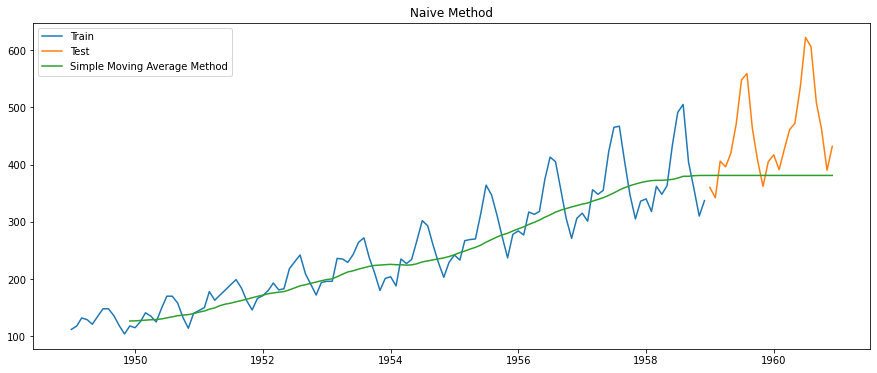

In [464]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_sma['sma_forcast'], label = 'Simple Moving Average Method')
plt.legend(loc='best')

plt.title("Naive Method")
plt.show()

In [465]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_sma['sma_forcast'][train_len:])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_sma['sma_forcast'][train_len:] )/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Simple Moving Average Method'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796


# Simple Exponential Smoothing

In [466]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers_Linear_Interpolation'])
model_fit = model.fit(smoothing_level=0.2, optimized = False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

### Plot the timeseries

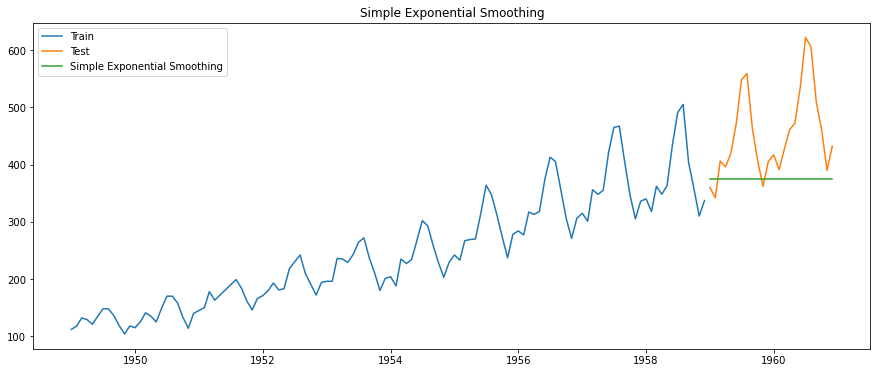

In [467]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_ses['ses_forecast'], label = 'Simple Exponential Smoothing')
plt.legend(loc='best')
plt.title("Simple Exponential Smoothing")
plt.show()

In [468]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_ses['ses_forecast'])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_ses['ses_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Simple Exponential Smoothing'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062


# Holt's Exponential Smoothing Method with Trend

In [469]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers_Linear_Interpolation']), seasonal_periods=12, trend = 'additive', seasonal= None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope = 0.01, optimized = False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['ses_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


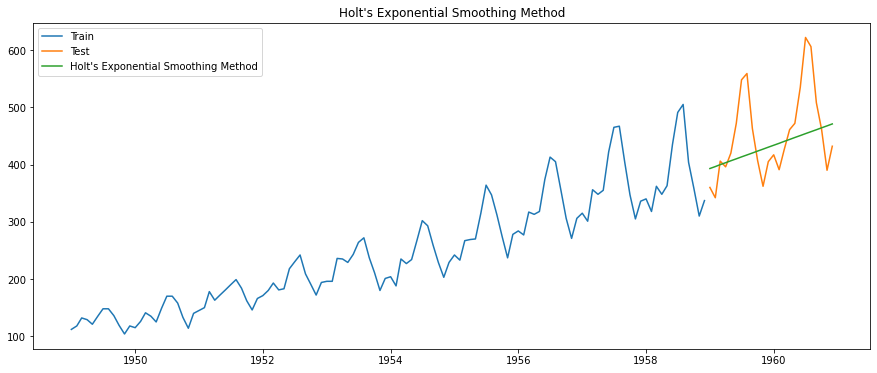

In [470]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_holt['ses_forecast'], label = "Holt's Exponential Smoothing Method")
plt.legend(loc='best')
plt.title("Holt's Exponential Smoothing Method")
plt.show()

In [471]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_holt['ses_forecast'])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_holt['ses_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Holts Exponential Smoothing'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820


# Holt Winters' Additive Method with Trend and Seasonality

In [472]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers_Linear_Interpolation']),seasonal_periods = 12, trend = 'add', seasonal = 'add')
model_fit = model.fit(optimized = True)
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2631578931410027, 'smoothing_slope': 0.051629609669344684, 'smoothing_seasonal': 0.7368421036673185, 'damping_slope': nan, 'initial_level': 211.55095646956713, 'initial_slope': 1.7392246944070349, 'initial_seasons': array([-100.18100004,  -94.20460308,  -80.29175705,  -83.41741833,
        -91.4588691 ,  -77.45075901,  -64.48315087,  -64.57323444,
        -76.66637227,  -93.73569929, -108.67594369,  -94.50939263]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


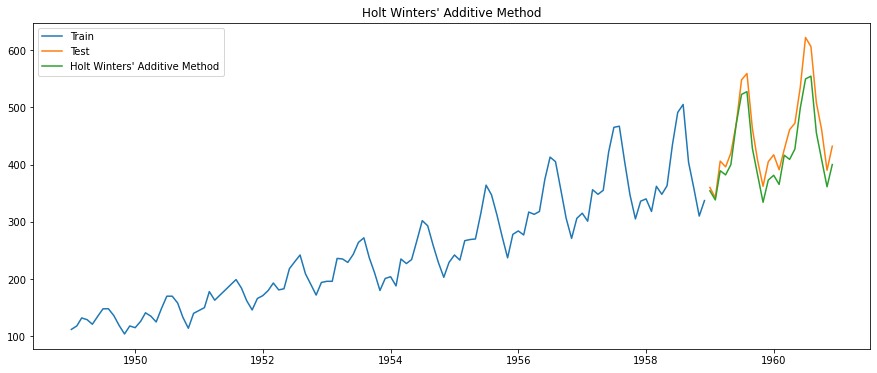

In [473]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_hwa['hwa_forecast'], label = "Holt Winters' Additive Method")
plt.legend(loc='best')
plt.title("Holt Winters' Additive Method")
plt.show()

In [474]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_hwa['hwa_forecast'])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_hwa['hwa_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Holt Winters Additive '], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820
0,Holt Winters Additive,6.53,35.095299


# Holt Winters' Multiplicative Method with Trend and Seasonality

In [475]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers_Linear_Interpolation']),seasonal_periods = 12, trend = 'add', seasonal = 'mul')
model_fit = model.fit(optimized = True)
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.31580581018709464, 'smoothing_slope': 0.05260848110727645, 'smoothing_seasonal': 0.6841937536320254, 'damping_slope': nan, 'initial_level': 212.3994336992903, 'initial_slope': 1.085375716722051, 'initial_seasons': array([0.53914448, 0.56338115, 0.62003024, 0.59046106, 0.54601563,
       0.60904202, 0.67056349, 0.66988215, 0.61256313, 0.53224851,
       0.47048424, 0.54762413]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


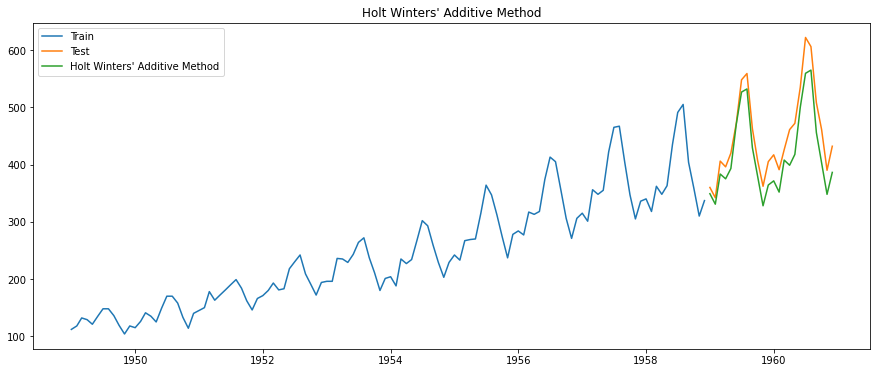

In [476]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_hwa['hwa_forecast'], label = "Holt Winters' Additive Method")
plt.legend(loc='best')
plt.title("Holt Winters' Additive Method")
plt.show()

In [477]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_hwa['hwa_forecast'])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_hwa['hwa_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Holt Winters Multiplicative'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820
0,Holt Winters Additive,6.53,35.095299
0,Holt Winters Multiplicative,7.66,38.368607


In [482]:
model_fit.forecast(1)

array([349.06333047])

# Stationarity Tests

# Augmented Dickey-Fuller (ADF) Test 

In [483]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers_Linear_Interpolation'])
print("ADF Statistics : %f" % adf_test[0])
print("Critical Value @ 0.05: %.2f" % adf_test[4]['5%'])
print('p-value: %f ' % adf_test[1])

ADF Statistics : 0.894609
Critical Value @ 0.05: -2.88
p-value: 0.993020 


As per Augmented Dickey-Fuller (ADF) Test 
- Null Hypothesis (H0): The series is not stationary
     - p−value>0.05
- Alternate Hypothesis (H1): The series is stationary
     - p−value≤0.05

# KPSS Test

In [484]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers_Linear_Interpolation'])
print("ADF Statistics : %f" % kpss_test[0])
print("Critical Value @ 0.05: %.2f" % kpss_test[3]['5%'])
print('p-value: %f ' % kpss_test[1])

ADF Statistics : 1.052050
Critical Value @ 0.05: 0.46
p-value: 0.010000 


- Null Hypothesis (H0): The series is stationary
    - p−value>0.05
- Alternate Hypothesis (H1): The series is not stationary
    - p−value≤0.05

# Non-Stationary to Stationary

## Box Cox Transformation

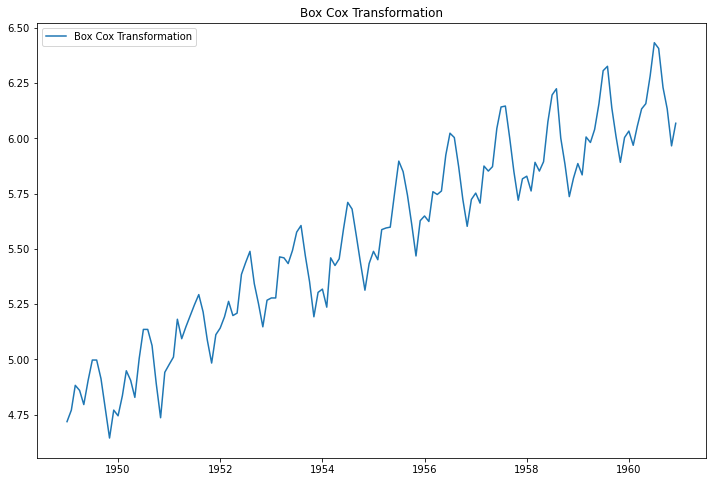

In [485]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers_Linear_Interpolation'], lmbda = 0), index =data.index)
plt.plot(data_boxcox , label = 'Box Cox Transformation')
plt.legend(loc='best')
plt.title("Box Cox Transformation")
plt.show()

# Differentiating

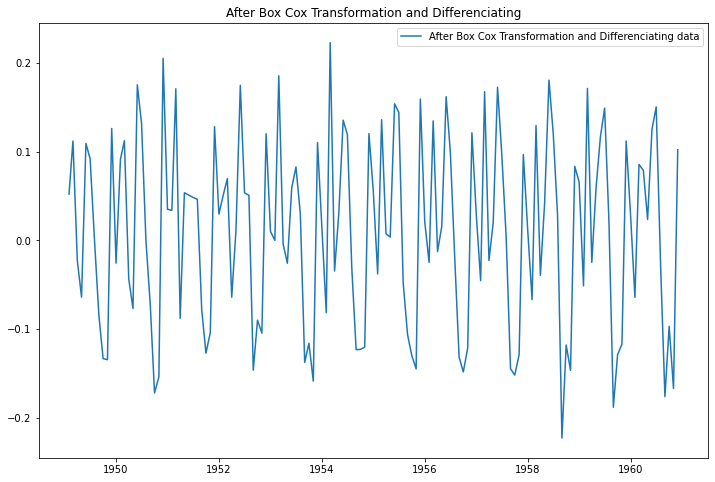

In [486]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = data.index)
data_boxcox_diff.dropna(inplace= True)
plt.plot(data_boxcox_diff , label = 'After Box Cox Transformation and Differenciating data')
plt.legend(loc='best')
plt.title("After Box Cox Transformation and Differenciating")
plt.show()

In [487]:
kpss_test = kpss(data_boxcox_diff)
print("ADF Statistics : %f" % kpss_test[0])
print("Critical Value @ 0.05: %.2f" % kpss_test[3]['5%'])
print('p-value: %f ' % kpss_test[1])

ADF Statistics : 0.101871
Critical Value @ 0.05: 0.46
p-value: 0.100000 


In [488]:
adf_test = adfuller(data_boxcox_diff)
print("ADF Statistics : %f" % adf_test[0])
print("Critical Value @ 0.05: %.2f" % adf_test[4]['5%'])
print('p-value: %f ' % adf_test[1])

ADF Statistics : -3.290114
Critical Value @ 0.05: -2.88
p-value: 0.015326 


# Autocorrelation function (ACF) plot

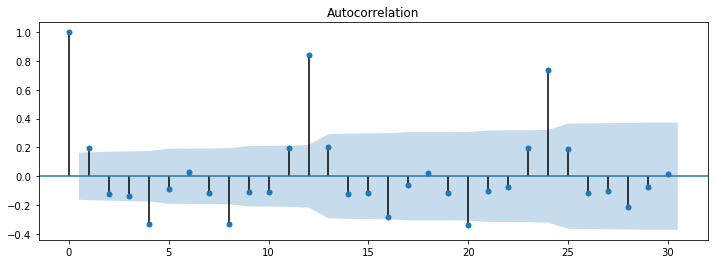

In [489]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize = (12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(),lags=30)
plt.show()

# Partial autocorrelation function (ACF) plot

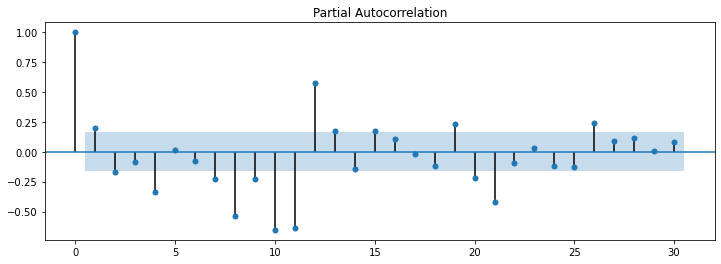

In [490]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize = (12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(),lags=30)
plt.show()

# Spliting data into train and test

In [491]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

# Auto Regression Model

In [492]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1,0,0))
model_fit = model.fit()
print(model_fit.params)

const      0.009477
ar.L1.y    0.183116
dtype: float64


# Recover orignal time series forecast

In [493]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [505]:
model_fit.predict('1959-01-01','1970-12-01')

1959-01-01    0.023034
1959-02-01    0.011959
1959-03-01    0.009931
1959-04-01    0.009560
1959-05-01    0.009492
                ...   
1970-08-01    0.009477
1970-09-01    0.009477
1970-10-01    0.009477
1970-11-01    0.009477
1970-12-01    0.009477
Freq: MS, Length: 144, dtype: float64

In [497]:
 data_boxcox_diff.index.min()

Timestamp('1949-02-01 00:00:00')

## Plot train, test and forecast

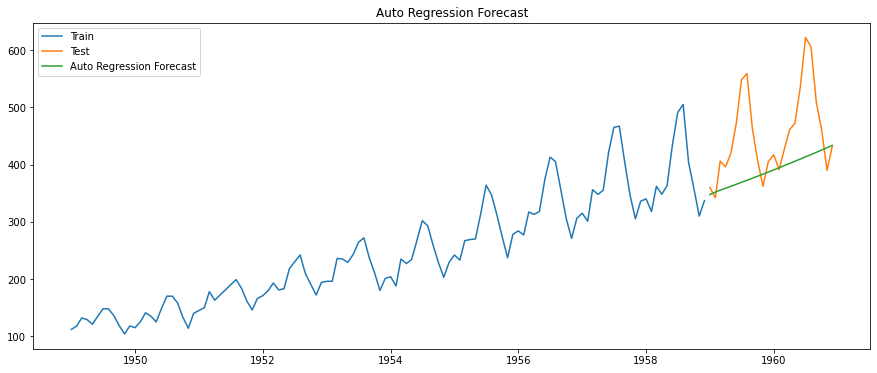

In [404]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label = "Auto Regression Forecast")
plt.legend(loc='best')
plt.title("Auto Regression Forecast")
plt.show()

In [405]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_ar['ar_forecast'][test.index.min():test.index.max()])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_ar['ar_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Auto Regression Forecast'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820
0,Holt Winters Additive,6.53,35.095299
0,Holt Winters Multiplicative,7.66,38.368607
0,Auto Regression Forecast,13.77,93.386187


# Moving Avarage (MA) Model

In [406]:
model = ARIMA(train_data_boxcox_diff, order=(0,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.009538
ma.L1.y    0.266103
dtype: float64


In [407]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

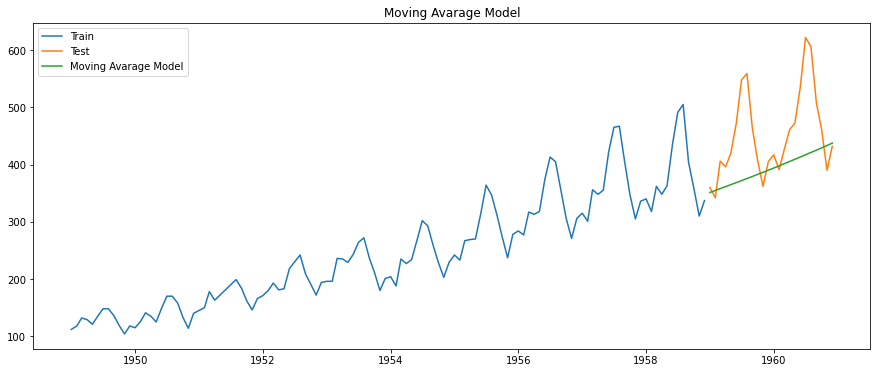

In [408]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label = "Moving Avarage Model")
plt.legend(loc='best')
plt.title("Moving Avarage Model")
plt.show()

# Calculate RMSE and MAPE

In [409]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_ma['ma_forecast'][test.index.min():test.index.max()])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_ma['ma_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Moving Avarage Model'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820
0,Holt Winters Additive,6.53,35.095299
0,Holt Winters Multiplicative,7.66,38.368607
0,Auto Regression Forecast,13.77,93.386187
0,Moving Avarage Model,13.39,91.205537


# Auto regressive moving average (ARMA) method

In [410]:
model = ARIMA(train_data_boxcox_diff, order=(1,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64


## Recover the orignal timeseries forcast

In [411]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

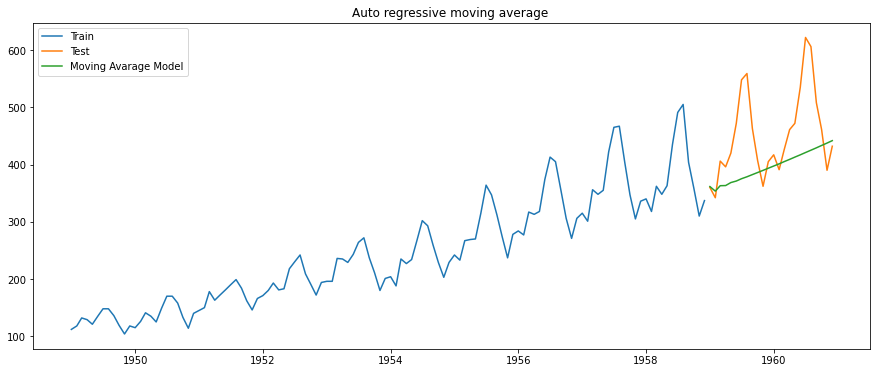

In [412]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label = "Moving Avarage Model")
plt.legend(loc='best')
plt.title("Auto regressive moving average ")
plt.show()

In [413]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_arma['arma_forecast'][test.index.min():test.index.max()])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_arma['arma_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Auto Regresive Moving Avarage Model'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820
0,Holt Winters Additive,6.53,35.095299
0,Holt Winters Multiplicative,7.66,38.368607
0,Auto Regression Forecast,13.77,93.386187
0,Moving Avarage Model,13.39,91.205537
0,Auto Regresive Moving Avarage Model,12.89,88.879188


# Auto Regressive Integrated Moving Average (ARIMA)

In [416]:
model = ARIMA(train_data_boxcox,order=(1,1,1))
model_fit = model.fit()
print(model_fit.params)

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64


In [417]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

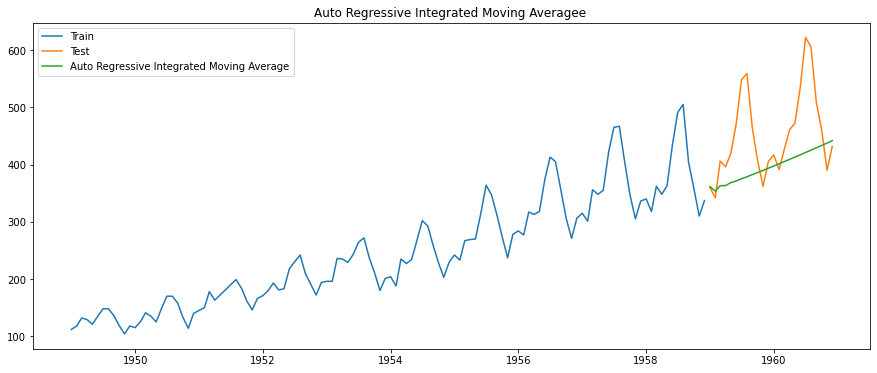

In [418]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label = "Auto Regressive Integrated Moving Average")
plt.legend(loc='best')
plt.title("Auto Regressive Integrated Moving Averagee ")
plt.show()

In [420]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_arima['arima_forecast'][test.index.min():test.index.max()])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_arima['arima_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['Auto Regressive Integrated Moving Average'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820
0,Holt Winters Additive,6.53,35.095299
0,Holt Winters Multiplicative,7.66,38.368607
0,Auto Regression Forecast,13.77,93.386187
0,Moving Avarage Model,13.39,91.205537
0,Auto Regresive Moving Avarage Model,12.89,88.879188


# Seasonal Auto Regressive Integrated Moving Average

In [424]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data_boxcox, order = (1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.386969
ma.L1      -0.677689
ar.S.L12   -0.043191
ma.S.L12   -0.515284
sigma2      0.001406
dtype: float64


### Recover orignal time series forecast

In [425]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

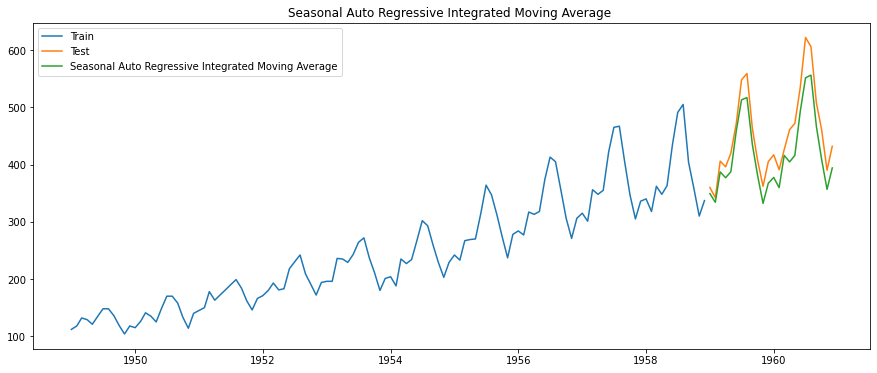

In [427]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label = "Seasonal Auto Regressive Integrated Moving Average")
plt.legend(loc='best')
plt.title("Seasonal Auto Regressive Integrated Moving Average ")
plt.show()

In [428]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_sarima['sarima_forecast'][test.index.min():test.index.max()])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_sarima['sarima_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['SARIMA'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820
0,Holt Winters Additive,6.53,35.095299
0,Holt Winters Multiplicative,7.66,38.368607
0,Auto Regression Forecast,13.77,93.386187
0,Moving Avarage Model,13.39,91.205537
0,Auto Regresive Moving Avarage Model,12.89,88.879188


# SARIMAX

In [429]:
promo = pd.read_csv('promotion.csv',header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format = '%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


In [430]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

In [431]:
model = SARIMAX(train_data_boxcox, order = (1,1,1), seasonal_order=(1,1,1,12), exog=promo_train)
model_fit = model.fit()
print(model_fit.params)

Event       0.034382
ar.L1       0.481868
ma.L1      -0.744174
ar.S.L12   -0.061580
ma.S.L12   -0.560375
sigma2      0.001334
dtype: float64


### Recover orignal TS forcast data

In [432]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(test.index.min(),test.index.max(), exog= promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

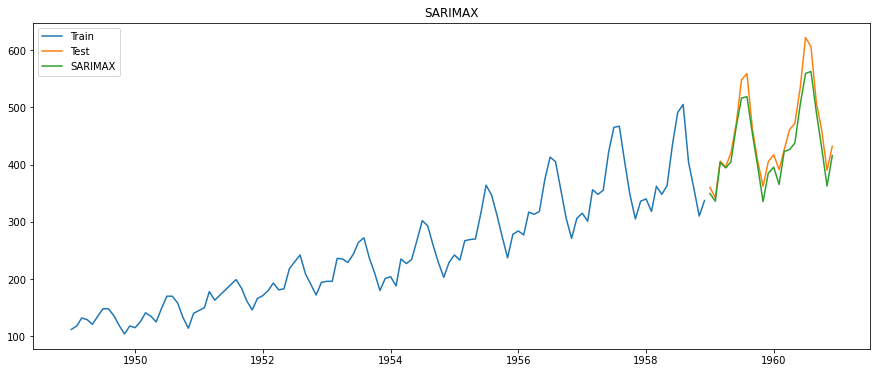

In [433]:
plt.figure(figsize=(15,6))
plt.plot(train['Passengers_Linear_Interpolation'], label = 'Train')
plt.plot(test['Passengers_Linear_Interpolation'], label = 'Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label = "SARIMAX")
plt.legend(loc='best')
plt.title("SARIMAX")
plt.show()

In [434]:
rsme = np.sqrt((mean_squared_error(test['Passengers_Linear_Interpolation'],y_hat_sarimax['sarimax_forecast'][test.index.min():test.index.max()])).round(2))
mape = np.round(np.mean(np.abs(test['Passengers_Linear_Interpolation'] - y_hat_sarimax['sarimax_forecast'])/test['Passengers_Linear_Interpolation'])*100,2)
result = pd.DataFrame({'Method':['SARIMAX'], 'MAPE':[mape],'RSME':[rsme]})
results = pd.concat([results,result])
results

,Method,MAPE,RSME
0,Naive Method,23.63,137.510436
0,Avarage Method,44.28,219.689485
0,Simple Moving Average Method,15.54,103.331796
0,Simple Exponential Smoothing,16.49,107.647062
0,Holts Exponential Smoothing,11.11,71.937820
0,Holt Winters Additive,6.53,35.095299
0,Holt Winters Multiplicative,7.66,38.368607
0,Auto Regression Forecast,13.77,93.386187
0,Moving Avarage Model,13.39,91.205537
0,Auto Regresive Moving Avarage Model,12.89,88.879188
